In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from numpy.random import randint
from numpy.random import rand
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from scipy.integrate import cumulative_trapezoid
import math
# https://www.geeksforgeeks.org/cubic-spline-interpolation/#:~:text=Cubic%20spline%20interpolation%20is%20a,second%20derivatives%20where%20they%20join.
from scipy.interpolate import CubicSpline

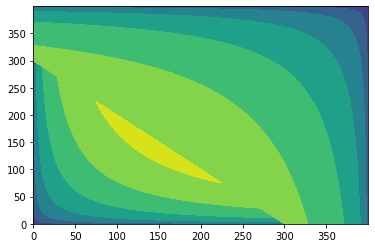

In [2]:
x = np.arange(0,400,0.2)
y = np.arange(0,400,0.2)
[x, y] = np.meshgrid(x, y)
k = 400
row = len(x)
x = x.flatten()
y = y.flatten()
z = [(k-x[i])**0.2*(k-y[i])**0.2/130 if x[i]+y[i]>300 else (x[i])**0.2*(y[i])**0.2/100 for i in range(len(x))]
z = np.array(z)
x = x.reshape(row,row)
y = y.reshape(row,row)
z = z.reshape(row,row)
fig, ax = plt.subplots(1, 1)
ax.contourf(x,y,z)
plt.show()


## Useful functions

In [3]:
# constant parameters
mass = 100
Urr = 0.03
g = 9.81
a0=1
a1=1
a2=1
points = 400
wheel_radius = 0.3
gear_ratio = 5

def interpolate(x_data, y_data, num_points, plot=False):
  # y_f = interp1d(x_data, y_data, 'cubic')
  y_f = CubicSpline(x_data,y_data)
  x = np.linspace(x_data[0],x_data[-1],num_points)
  y = y_f(x)
  # Plotting
  if plot:
    plt.scatter(x,y,marker=".")
    plt.scatter(x_data,y_data,c="red")
    plt.ylabel("Velocity")
    plt.show()
  return x,y

# function to integrate
def integrate(x_data, y_data,plot=False):
  integral = cumulative_trapezoid(y_data,x_data, initial=0)
  # plt.plot(x_data, integral)
  # plt.xlabel('Time [ns]')
  # plt.ylabel('Integrated Current [pC]')
  # plt.show()
  return integral[-1]

# finding out accelration
def fun_acc(inter_disp, inter_vel):
  acceleration = np.gradient(inter_vel,inter_disp) * inter_vel
  return acceleration

# Constraints on acceleration
def acc_min_constraint(vel_s):
  acc_s = fun_acc(vel_s)
  return acc_s + 4
def acc_max_constraint(vel_s):
  acc_s = fun_acc(vel_s)
  return acc_s-3


# function to find traction force
def fun_traction_force(velocity, acceleration):
  return mass*g*(a0+a1*velocity+a2*velocity*velocity) + mass*acceleration
  # return mass*g*(a0+a1*velocity+a2*velocity*velocity)

# function to find total energy
def fun_total_energy(traction_force,displacement):
  energy = integrate(x_data=displacement, y_data=traction_force)
  return energy

# fitness function
def fitness_function(displacement, velocity, plot=False):
  # interpolate
  inter_disp,inter_vel=interpolate(displacement, velocity, points, plot=plot)
  # find acceleration
  acceleration = fun_acc(inter_disp=inter_disp,inter_vel=inter_vel)
  # find traction force
  traction_force = fun_traction_force(velocity=inter_vel,acceleration=acceleration)
  # if traction force is negative make it zero
  traction_force = [0 if _<0 else _ for _ in traction_force]
  # find motor torque and rpm and efficiency
  # np_traction_force = np.array(traction_force)
  motor_torque = np.array(traction_force) * wheel_radius / gear_ratio 
  motor_rpm = np.absolute(np.array(inter_vel)) / wheel_radius * gear_ratio * 60 / 2 / math.pi 
  elec_eff = motor_torque * motor_rpm / 300
  # find output force
  traction_force = np.array(traction_force)/(elec_eff+0.1)
  # find total energy
  total_energy = fun_total_energy(traction_force=traction_force,displacement=inter_disp) 
  
  return total_energy


In [4]:
# declaring velocity points
displacement = [0,25,50,75,125,150,175,225,250,275,325,350,375,400]
def gen_random_velocity():
  velocity = [0]
  for i in range(3):
    velocity.append(randint(5,10))
  for i in range(3):
    velocity.append(randint(5,10))
  for i in range(3):
    velocity.append(randint(5,10))
  for i in range(3):
    velocity.append(randint(5,10))
  velocity.append(0)
  return velocity


## Effiency map for our motor

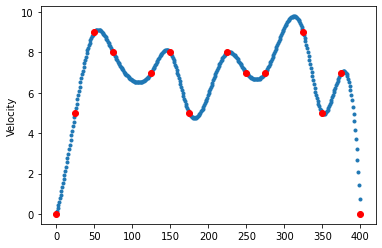

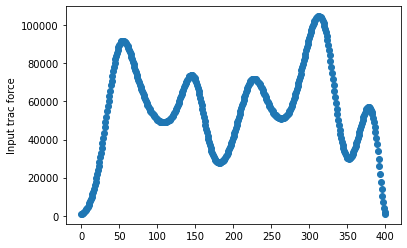

104639.88242316016


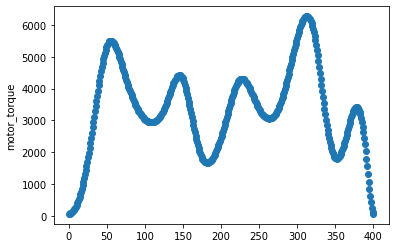

104639.88242316016


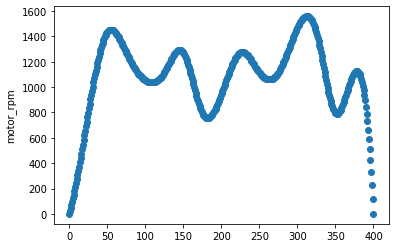

6128219.9279529825

In [5]:
vel = gen_random_velocity()
disp, inter_vel = interpolate(displacement, vel, 400, plot=True)
acceleration = fun_acc(inter_disp=disp,inter_vel=inter_vel)
trac_force = fun_traction_force(velocity=inter_vel,acceleration=acceleration)
plt.scatter(disp,trac_force)
plt.ylabel("Input trac force")
plt.show()
print(max(trac_force))
trac_force_input = [0 if _<0 else _ for _ in trac_force]
motor_torque = np.array(trac_force_input) * wheel_radius / gear_ratio 
motor_rpm = np.absolute(np.array(inter_vel)) / wheel_radius * gear_ratio * 60 / 2 / math.pi 
elec_eff = motor_torque * motor_rpm / 1000000
trac_force_output = np.array(trac_force_input)/(elec_eff+0.1)
plt.scatter(disp,motor_torque)
plt.ylabel("motor_torque")
plt.show()
print(np.amax(trac_force))
plt.scatter(disp,motor_rpm)
plt.ylabel("motor_rpm")
plt.show()
total_energy = fun_total_energy(traction_force=trac_force_output,displacement=disp)
total_energy

6278.39294538961 1558.391855032115
91.67010911953618 89.69132779128014


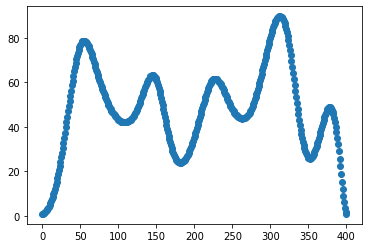

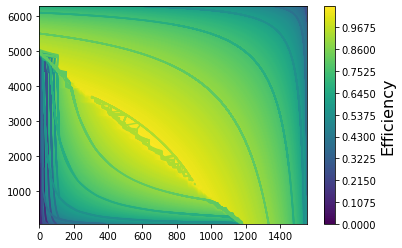

In [20]:
torque_max = 7000
rpm_max = 1700
print(max(motor_torque), max(motor_rpm))
torque_scaled = motor_torque/torque_max*100
rpm_scaled = motor_rpm/rpm_max*100
plt.scatter(disp,torque_scaled)
# plt.ylabel("motor_torque")
# plt.show()C = 
# plt.scatter(disp,rpm_scaled)
# plt.ylabel("motor_rpm")
# plt.show()

x = rpm_scaled
y = torque_scaled
[x, y] = np.meshgrid(x, y)
k = 92
row = len(x)
x = x.flatten()
y = y.flatten()
print(max(x), max(y))
z = [(k-x[i])**0.18*(k-y[i])**0.18/100 if x[i]+y[i]>70 else (x[i])**0.2*(y[i])**0.2/100 for i in range(len(x))]
z = np.array(z)
z = z*25
x = x.reshape(row,row)
y = y.reshape(row,row)
z = z.reshape(row,row)
fig, ax = plt.subplots(1, 1)
C = ax.contourf(x*rpm_max/100,y*torque_max/100,z,np.linspace(z.min(), z.max(), 300))
# C = ax.contourf(x,y,z,np.linspace(z.min(), z.max(), 300))
ax.contour(x*rpm_max/100,y*torque_max/100,z)
cbar = plt.colorbar(C)
cbar.set_label("Efficiency", fontsize = 16)
plt.show()

In [22]:
x = 50
y = 20
k=92
if x+y>70:
  eff = (k-x)**0.18*(k-y)**0.18/100
else:
  eff = (x)**0.2*(y)**0.2/100
eff*25

0.9952679263837432

In [21]:
torque_max = 7000
rpm_max = 1700
def eff_helper(x,y):
  k=92
  # check for values out of range
  if(x>=k or y>=k or x<=0 or y<=0): 
    return 0
  return (k-x)**0.18*(k-y)**0.18/100 if x+y>70 else (x)**0.2*(y)**0.2/100 
def find_eff(motor_torque, motor_rpm):
  x = [i/torque_max*100 for i in motor_torque]
  y = [i/rpm_max*100 for i in motor_rpm]
  k = 92
  row = len(x)
  z = [eff_helper(x[i],y[i]) for i in range(len(x))]
  z = np.array(z)
  z = z*25
  return z,x,y

motor_torque = [906,400,5000,6000]
motor_rpm = [1273,900,1000,1500]
find_eff(motor_torque, motor_rpm)

(array([0.91535454, 0.78359403, 0.80923944, 0.44185058]),
 [12.942857142857141, 5.714285714285714, 71.42857142857143, 85.71428571428571],
 [74.88235294117646, 52.94117647058824, 58.82352941176471, 88.23529411764706])